- By: Oleksandr Proskurin
- Email: proskurinolexandr@gmail.com
- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 40

# ETF trick use case. SPX/EuroStoxx hedging implementation

Let's see how mlfinlab etf trick is used to solve the exercise 2.3 from Chapter 2. For this exercise we use daily SPY and EUROSTOXX futures data and EUR/USD exchange rates from https://www.investing.com/. Hedging weights are recalculated on a daily basis

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from packages.etf_trick import ETFTrick

In [2]:
def generate_cov_mat(row):
    """
    Forms covariance matrix from current data frame row using 'rolling_cov', 
    'rolling_spx_var' and 'rolling_eur_var' column values
    """
    cov = row['rolling_cov']
    spx_var = row['rolling_spx_var']
    euro_var = row['rolling_euro_var']
    return np.matrix([[spx_var, cov], [cov, euro_var]])

In [3]:
# Snippet 2.1 from a book
def pca_weights(cov, riskDist=None, risk_target = 1.):
    """
    Calculates hedging weights using covariance matrix(cov), risk distribution(riskDist) and risk_target
    """
    eVal, eVec = np.linalg.eigh(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1.
    loads = risk_target * (riskDist/eVal)**.5
    wghts = np.dot(eVec, np.reshape(loads, (-1,1)))
    return wghts

# Data preprocessing

In [5]:
spx = pd.read_csv('./Sample-Data/spx.csv', usecols=['Date', 'Price', 'Open'])
euro = pd.read_csv('./Sample-Data/eurostoxx.csv', usecols=['Date', 'Price', 'Open'])
eur_usd = pd.read_csv('./Sample-Data/eur_usd.csv', usecols = ['Date', 'Price'])

In [6]:
# rename columns to universal format
spx.rename(columns = {'Date': 'date', 'Price': 'close', 'Open': 'open'}, inplace=True) 
euro.rename(columns = {'Date': 'date', 'Price': 'close', 'Open': 'open'}, inplace=True)
eur_usd.rename(columns = {'Date': 'date', 'Price': 'close'}, inplace=True)

In [7]:
spx['date'] = pd.to_datetime(spx.date) #convert date column to datetime format
euro['date'] = pd.to_datetime(euro.date)
eur_usd['date'] = pd.to_datetime(eur_usd.date)

In [8]:
# convert price data from strings to float (investing.com uses specific decimal sep format)
spx.close = spx.close.apply(lambda x: x.replace(',', '')).astype(float)
euro.close = euro.close.apply(lambda x: x.replace(',', '')).astype(float)
spx.open = spx.open.apply(lambda x: x.replace(',', '')).astype(float)
euro.open = euro.open.apply(lambda x: x.replace(',', '')).astype(float)

In [9]:
spx.set_index('date', inplace=True)
euro.set_index('date', inplace=True)
eur_usd.set_index('date', inplace=True)

In [10]:
spx.sort_index(inplace=True)
euro.sort_index(inplace=True)
eur_usd.sort_index(inplace=True)

In [11]:
eur_usd = eur_usd[eur_usd.index.isin(spx.index)] # exchange rate is needed only for dates when futures are traded

# Generate covariances and hedging weights

In [12]:
cov_df = pd.DataFrame(index=spx.index) # init data frame with covariance and price data

In [14]:
cov_df.loc[spx.index, 'spx_close'] = spx.loc[:, 'close']
cov_df.loc[euro.index, 'euro_close'] = euro.loc[:, 'close']
cov_df.loc[spx.index, 'spx_open'] = spx.loc[:, 'open']
cov_df.loc[euro.index, 'euro_open'] = euro.loc[:, 'open']
cov_df.loc[eur_usd.index, 'eur_usd'] = eur_usd.loc[:, 'close']
cov_df['euro_fx_adj'] = cov_df.euro_close / cov_df.eur_usd # we need to calculate EUROSTOXX returns adjusted for FX rate
cov_df['spx'] = cov_df.spx_close.pct_change().fillna(0)
cov_df['euro'] = cov_df.euro_fx_adj.pct_change(fill_method=None).fillna(0)

In [15]:
# fill missing values with previous ones
cov_df.update(cov_df.loc[:, ['spx', 'euro', 'spx_close', 'spx_open', 'euro_close', 'euro_open', 'eur_usd']].fillna(method='pad'))

/var/folders/25/p425ch954x3b1x5b51flbpmw0000gn/T/ipykernel_49664/1091811547.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cov_df.update(cov_df.loc[:, ['spx', 'euro', 'spx_close', 'spx_open', 'euro_close', 'euro_open', 'eur_usd']].fillna(method='pad'))


In [16]:
cov_df.sort_index(inplace=True)

In [17]:
# get 252 rolling covariance between SPY and EUROSTOXX, rolling variances
cov_df['rolling_cov'] = cov_df['spx'].rolling(window=252).cov(cov_df['euro']) 
cov_df['rolling_spx_var'] = cov_df['spx'].rolling(window=252).var()
cov_df['rolling_euro_var'] = cov_df['euro'].rolling(window=252).var()

In [18]:
# iterate over cov_df and on each step define hedging weights using pca_weights function
cov_df.dropna(inplace=True)
for index, row in cov_df.iterrows():
    mat = generate_cov_mat(row)
    w = pca_weights(mat)
    cov_df.loc[index, 'spx_w'] = w[0]
    cov_df.loc[index, 'euro_w'] = w[1]

# Prepare data set for ETF trick

ETFTrick class requires open_df, close_df, alloc_df, costs_df, rates_df. Each of these data frames should be in  a specific format:

    1) DateTime index
    2) Each column name corresponds to a ticker, number of columns in all data frames should be equal.In our case all   data frames contain columns: 'spx' and 'euro'. 
    For example, we implement etf trick with 5 securities: A, B, C, D, E. If for the first two years only A, B and C close data is available while for the last two years only D and E data is available, close data frame format will be:
    index        A    B     C     D     E
    Year 1      22.0 7.52  7.5   NaN   NaN
    Year 1      20.7 7.96  8.2   NaN   NaN
    .....
    Year N      NaN  NaN   NaN   0.3   100.5
   
__open_df__: _open prices (in contract currency)_

__close_df__: _close prices_

__alloc_df__: _securities allocation vector_

__costs_df__: _costs of holding/rebalancing the position_

__rates_df__: _$ value of 1 point move of contract price. This includes exchange rates, futures multipliers_

In [19]:
open_df = cov_df[['spx_open', 'euro_open']] # create open_df
open_df.rename(columns = {'spx_open': 'spx', 'euro_open': 'euro'}, inplace=True)

/var/folders/25/p425ch954x3b1x5b51flbpmw0000gn/T/ipykernel_49664/2045656389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_df.rename(columns = {'spx_open': 'spx', 'euro_open': 'euro'}, inplace=True)


In [20]:
close_df = cov_df[['spx_close', 'euro_close']] # create close_df
close_df.rename(columns = {'spx_close': 'spx', 'euro_close': 'euro'}, inplace=True)

/var/folders/25/p425ch954x3b1x5b51flbpmw0000gn/T/ipykernel_49664/3444788309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_df.rename(columns = {'spx_close': 'spx', 'euro_close': 'euro'}, inplace=True)


In [21]:
rates_df = 1/cov_df[['eur_usd']] # we need USD_EUR = 1/EUR_USD rate for EUROSTOXX price movements
rates_df.rename(columns = {'eur_usd': 'euro'}, inplace=True)
rates_df['spx'] = 1.0

In [22]:
alloc_df = cov_df[['spx_w', 'euro_w']] # allocations data frame with weights generated using pca_weights()
alloc_df.rename(columns={'spx_w': 'spx', 'euro_w': 'euro'}, inplace=True)

/var/folders/25/p425ch954x3b1x5b51flbpmw0000gn/T/ipykernel_49664/2412113836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc_df.rename(columns={'spx_w': 'spx', 'euro_w': 'euro'}, inplace=True)


In [23]:
costs_df = alloc_df.copy() # let's assume zero rebalancing costs
costs_df['spx'] = 0.0
costs_df['euro'] = 0.0

In [24]:
trick = ETFTrick(open_df, close_df, alloc_df,
                costs_df, rates_df, in_memory=True) # in_memory means that all data frames are stored in memory, if False open_df should be a path to open data frame

In [25]:
trick_series = trick.get_etf_series()

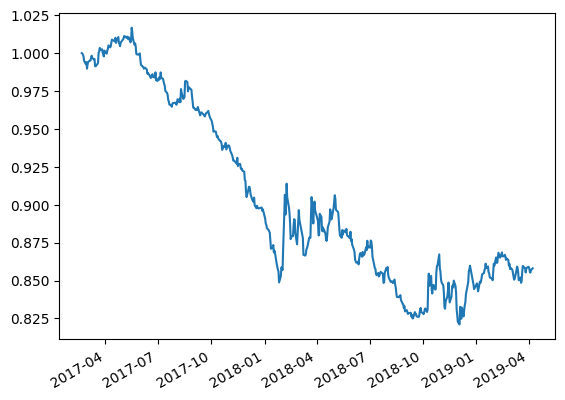

In [27]:
trick_series.plot()
plt.show()